## 개요

자전거 공유 시스템(Bike sharing systems)은 도시 전체의 키오스크 위치 네트워크를 통해 회원 가입, 대여, 반납하는 절차가 자동화된 자전거 대여 방법을 말한다. 이런 시스템을 사용하여, 사람들은 한 장소에서 자전거를 빌리고 필요에 따라 다른 장소로 반납할 수 있다.  
  
이러한 시스템에서 생성된 데이터는 이동 기간(duration of travel), 출발 위치(departure location), 도착 위치(arrival location) 및 경과 시간(time elapsed)을 명시적으로 기록하기 때문에 연구자들에게 매력적이다. 따라서 자전거 공유 시스템은 도시의 이동성을 연구하는 데 사용될 수 있는 센서 네트워크 역할을 한다.  
  
이번 대회에서 참가자들은 워싱턴 D.C.의 Capital Bikeshare program에서 **자전거 대여 수요를 예측(forecast bike rental demand)** 하기 위해 과거 사용 패턴을 날씨 데이터와 결합해야 한다.

## 데이터

2년 간의 시간당 rental data로 훈련 셋은 매월의 첫 19일까지, 테스트 셋은 20일부터 말일까지로 구성되어 있다.  
  
**목적: 테스트 셋의 매 시간 총 대여 자전거 수 예측**  
  
  
**datetime** 　　- hourly date + timestamp  
**season** 　　　- 1 = spring, 2 = summer, 3 = fall, 4 = winter  
**holiday** 　　　- whether the day is considered a holiday(휴일로 간주되는 날)  
**workingday** 　- whether the day is neither a weekend nor holiday(주말도 아니고 휴일도 아닌 날)  
**weather** 　　　- 1: Clear, Few clouds, Partly cloudy, Partly cloudy  
　　　　　　　　2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist  
　　　　　　　　3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds  
　　　　　　　　4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog   
**temp** 　　　　　- temperature in Celsius(섭씨 온도)  
**atemp** 　　　　- "feels like" temperature in Celsius(체감 온도)  
**humidity** 　　　- relative humidity(상대 습도)  
**windspeed** 　　- wind speed(풍속)  
**casual** 　　　　- number of non-registered user rentals initiated(등록되지 않은 사용자의 최초 렌탈 수)  
**registered** 　　- number of registered user rentals initiated(등록된 사용자의 최초 렌탈 수)   
**count** 　　　　　- number of total rentals(총 대여 수) (count = casual + registered)  

## 1. Load the module and data

In [75]:
import pandas as pd
import numpy as np
from scipy import stats
# visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 그래프에서 마이너스 폰트 깨짐 대처
mpl.rcParams['axes.unicode_minus'] = False

# treat time
from datetime import datetime
import calendar

In [2]:
train = pd.read_csv('train.csv')
print(train.shape)

(10886, 12)


In [3]:
# 총 10886행, 12열로 이루어진 데이터 프레임
# 범주형 변수인 season, holiday, workingday, weather가 모두 int형으로 되어있다.
train.info()        

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


In [4]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## 2. Feature Engineering

앞서 본 것처럼 "season", "holiday", "workingday", "weather" 열은 수치형으로 되어있기 때문에 이를 다음과 같은 기준으로 범주형 변수로 바꿔주고자 한다.  
  
- "datetime"열로부터 새로운 열 "date", "hour", "weekDay", "month" 를 생성한다.
- "season", "holiday", "workingday", "weather" 열을 범주형으로 바꾼다.
- 이미 유용한 열들을 생성했기에 "datetime"열을 버린다.

### Creating New Columns From "Datetime" Column

In [5]:
train['date'] = train['datetime'].apply(lambda x: x.split()[0])
train['hour'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[0])
train['weekDay'] = train['date'].apply(lambda dateString: calendar.day_name[datetime.strptime(dateString, "%Y-%m-%d").weekday()])
train['month'] = train['date'].apply(lambda x: calendar.month_name[datetime.strptime(x,'%Y-%m-%d').month])

In [6]:
train['season'] = train['season'].map({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})
train['weather'] = train['weather'].map({
    1:'Clear + Few clouds + Partly cloudy + Partly cloudy',
    2:'Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
    3:' Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
    4:'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog'
})

### Coercing To Category Type

In [7]:
categoryVariableList = ['hour','weekDay','month','season','weather','holiday','workingday']

for var in categoryVariableList:
    train[var] = train[var].astype('category')

### Dropping Unnecessary Column

In [8]:
train = train.drop(['datetime'], axis=1)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
season        10886 non-null category
holiday       10886 non-null category
workingday    10886 non-null category
weather       10886 non-null category
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
date          10886 non-null object
hour          10886 non-null category
weekDay       10886 non-null category
month         10886 non-null category
dtypes: category(7), float64(3), int64(4), object(1)
memory usage: 757.0+ KB


### Let's Start With Very Simple Visualization Of Variables DataType Count

In [10]:
dataType_df = pd.DataFrame(train.get_dtype_counts()).reset_index().rename(columns={'index':'variableType',0:'count'})

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'variable type'),
 Text(0.5, 1.0, 'Variables DataType Count')]

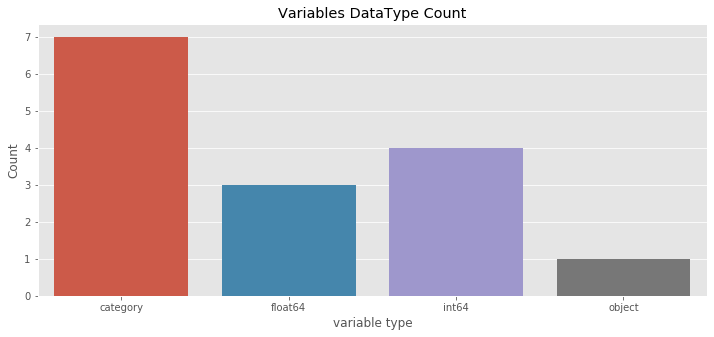

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.barplot(data=dataType_df, x='variableType', y='count' ,ax=ax)
ax.set(xlabel='variable type', ylabel='Count', title='Variables DataType Count')

## 3. Missing Values Analysis  
  
일단 우리가 데이터와 행에 대해 어느정도 알게 되었다면, 다음 단계로 데이터에 누락값이 존재하는 지 알아봐야한다. 운이 좋게도 이번 데이터에는 누락값이 없다. 일반적으로 데이터 셋에서 누락값을 시각화하는 방법은 missingno 라이브러리를 이용하는 것이다.

In [12]:
for col in train.columns:
    print('column: {:<10}\t # of NaN:{}'.format(col, train[col].isnull().sum()))

column: season    	 # of NaN:0
column: holiday   	 # of NaN:0
column: workingday	 # of NaN:0
column: weather   	 # of NaN:0
column: temp      	 # of NaN:0
column: atemp     	 # of NaN:0
column: humidity  	 # of NaN:0
column: windspeed 	 # of NaN:0
column: casual    	 # of NaN:0
column: registered	 # of NaN:0
column: count     	 # of NaN:0
column: date      	 # of NaN:0
column: hour      	 # of NaN:0
column: weekDay   	 # of NaN:0
column: month     	 # of NaN:0


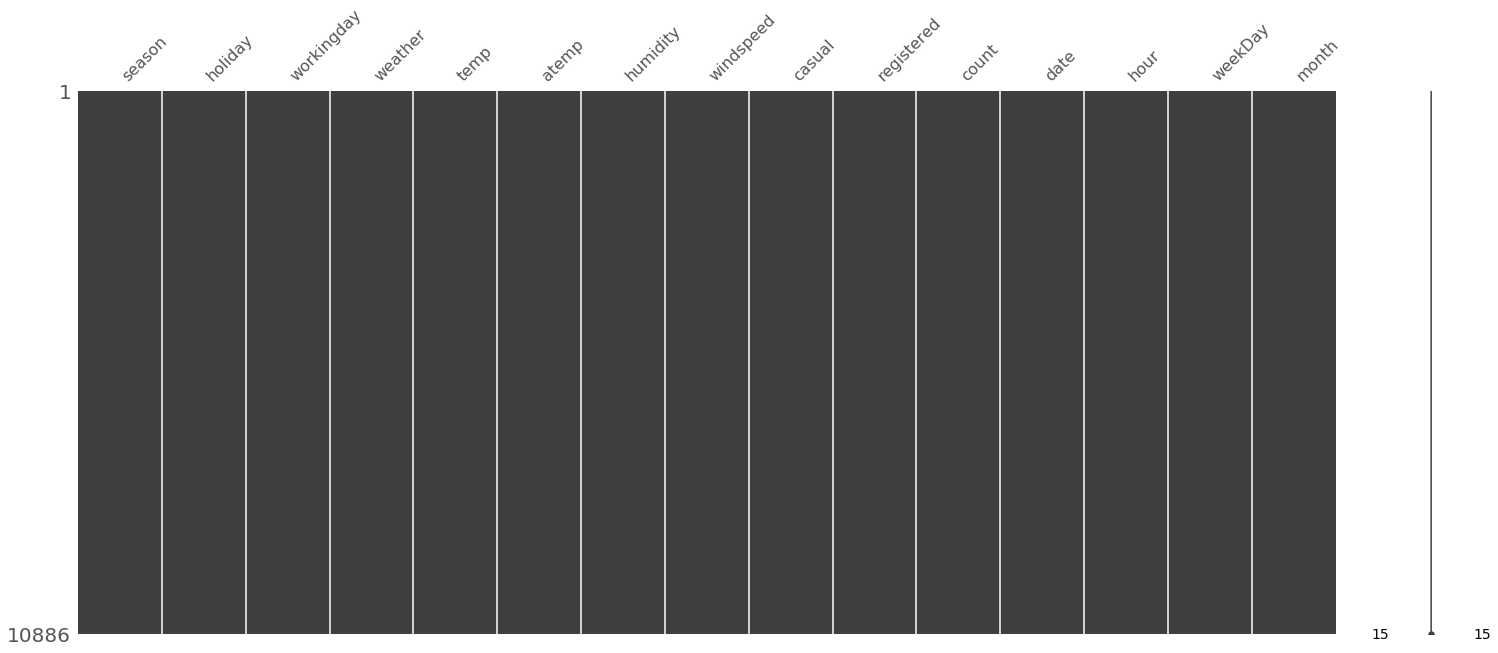

In [13]:
import missingno as msno
msno.matrix(train)

## 4. Outlier Analysis on "count" variable(target)
  
처음 그림에서, "count"변수는 분포를 **오른쪽으로 왜곡(skew)시키는 이상치 데이터 포인트가 있다**(박스플롯을 벗어나는 즉, IQR를 벗어나는). 그러나 이외에도 계절(season)별, 시간(hour)별, 평일(workingday)별 상자 그림을 통해 다음과 같은 추론이 만들어진다.

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

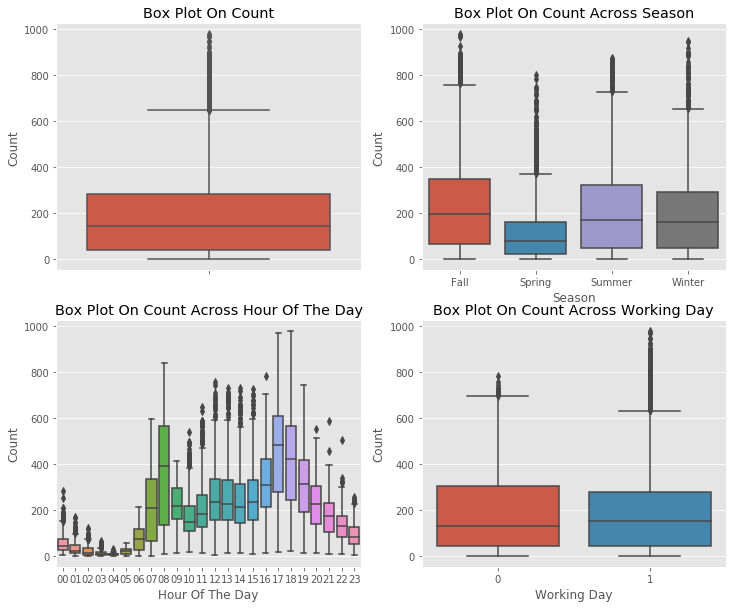

In [28]:
fig, axes = plt.subplots(2, 2, figsize=(12,10))

sns.boxplot(data=train, y='count', orient='v',ax=axes[0,0])
sns.boxplot(data=train, y='count', x='season', orient='v', ax=axes[0,1])
sns.boxplot(data=train, y='count', x='hour', orient='v', ax=axes[1,0])
sns.boxplot(data=train, y='count', x='workingday', orient='v', ax=axes[1,1])

axes[0,0].set(title='Box Plot On Count', ylabel='Count')
axes[0,1].set(title='Box Plot On Count Across Season', xlabel='Season', ylabel='Count')
axes[1,0].set(title='Box Plot On Count Across Hour Of The Day', xlabel='Hour Of The Day', ylabel='Count')
axes[1,1].set(title='Box Plot On Count Across Working Day', xlabel='Working Day', ylabel='Count')

- 그림 1) count 변수는 분포를 오른쪽으로 왜곡(skew)시키는 이상치 데이터 포인트가 있다
- 그림 2) 봄(season: Spring)에는 상대적으로 낮은 count를 가진다. 상자 그림에서 중   위수 값이 증거가 된다.
- 그림 3) 중위값이 7AM ~ 8AM 그리고 5PM ~ 6PM에 상대적으로 높다. 아마 학생이나 직   장인들의 출퇴근 시간이라 그런 것이라 추측가능하다.
- 그림 4) 대부분의 이상치는 주로 non-working day 보다는 Working Day에서 발생한다.

### Let's Remove Outliers In The Count Column  
  
- 이 노트북은 3 * 표준편차를 벗어나는 값을 이상치로 정의하였다.

In [40]:
trainWithoutOutliers = train[np.abs(train['count'] - train['count'].mean()) <= (3*train['count'].std())]

In [42]:
print("The shape of the before Outliers: {}".format(train.shape))
print("The shape of the after Outliers: {}".format(trainWithoutOutliers.shape))

The shape of the before Outliers: (10886, 15)
The shape of the after Outliers: (10739, 15)


Text(0.5, 1.0, 'Box Plot On Count Across Working Day')

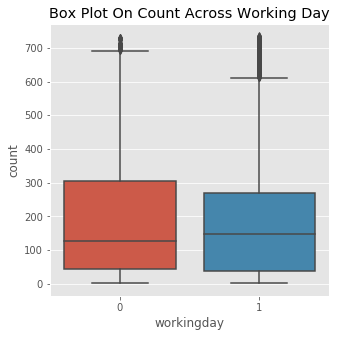

In [48]:
plt.figure(figsize=(5,5))
sns.boxplot(data=trainWithoutOutliers, y='count', x='workingday', orient='v')
plt.title('Box Plot On Count Across Working Day')

## 5. Correlation Analysis

종속 변수(Target)가 연속형 독립 변수(Feature)들에 의해 어떻게 영향을 받는지 알아보는 가장 흔한 방법은 그들 사이의 상관 행렬을 그려보는 것이다. 우선 'count' 변수와 ['temp', 'atemp', 'humidity', 'windspeed','casual','registered'] 사이의 correltion plot을 그려보자.  
- 연속형 vs 연속형: correlation plot

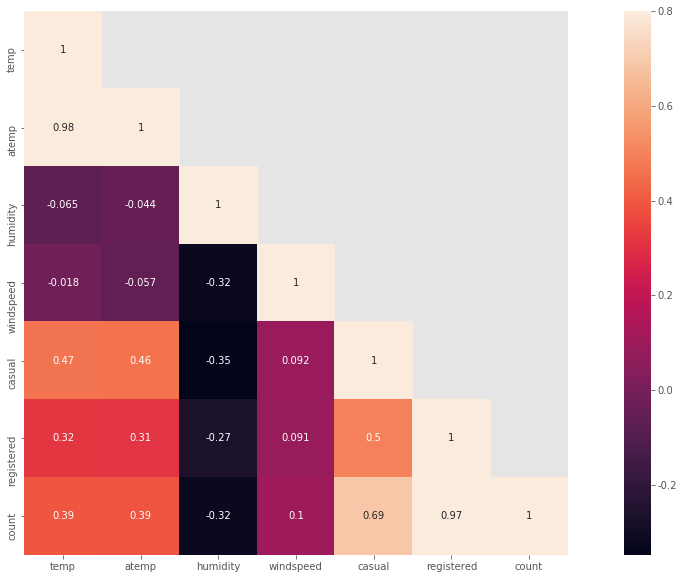

In [71]:
corrmatt = train[['temp','atemp','humidity','windspeed','casual','registered','count']].corr()

mask = np.array(corrmatt)
np.tril_indices_from(mask)
mask[np.tril_indices_from(mask)] = False    # np.tril_indices_from: Return the indices for the lower-triangle of array.
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrmatt, mask=mask, vmax=0.8, square=True, annot=True)

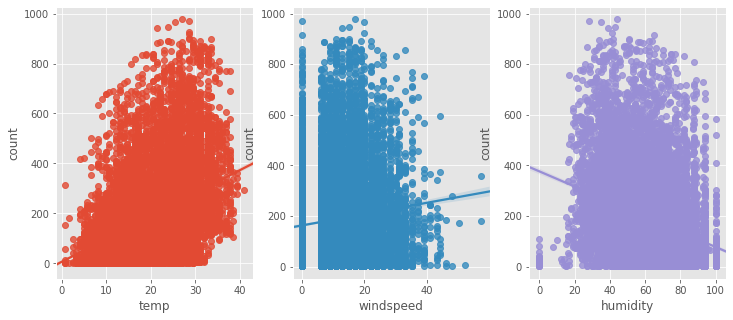

In [70]:
# sns.regplot: 회귀 직선 적합한 산점도
fig, ax = plt.subplots(1,3, figsize=(12, 5))

sns.regplot(x='temp', y='count', data=train, ax=ax[0])
sns.regplot(x='windspeed', y='count', data=train, ax=ax[1])
sns.regplot(x='humidity', y='count', data=train, ax=ax[2])

- temp(온도) 변수와 humidity(습도) 변수는 count 변수와 각각 양의 관계, 음의 관계를 보인다. temp와 humidity 사이의 상관관계는 매우 낮지만(-0.065), count 변수는 이 두 변수(vs_temp: 0.39, vs_humidity: -0.32)에 거의 의존하지 않는다.  
  
   
- windspeed(풍속)는 count와의 상관계수가 0.1로 별로 쓸만한 연속형 변수가 아니다.  
  
  
- atemp(체감온도)는 temp와 매우 강한 상관관계(0.98)을 가지기 때문에 쓰지 않을 것이다. 모델을 만드는 과정에서 다중공선성을 일으키기 때문이다.  
  
  
- casual과 registered 변수 역시 합하면 count변수가 되는 leakage variable로서 모델을 만드는 과정에서 버릴 것이다.

## 6. Visualizing Dist. Of Data

앞서 박스 플롯에서도 확인했듯이, count 변수는 오른쪽으로 치우친 분포를 가지고 있다(skewed towards right). 대부분의 머신러닝 모델은 종속 변수가 정규 분포를 따르는 가정을 필요로 하기 때문에, 정규 분포를 따르는 것이 바람직하다. 하나의 가능한 해결책은 count 변수에 **이상치를 제거한 후** 로그 변환(log transformation)을 취하는 것이다. 변수 변환(variable transformation)을 한 후의 count 변수는 훨씬 보기 좋아보이나, 여전히 이상적인 정규 분포를 따르지는 않는다.

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([0.        , 0.        , 0.        , ..., 6.59578051, 6.5971457 ,
         6.59850903])),
 (1.4096846101542908, 4.523106928071492, 0.9537631807794263))

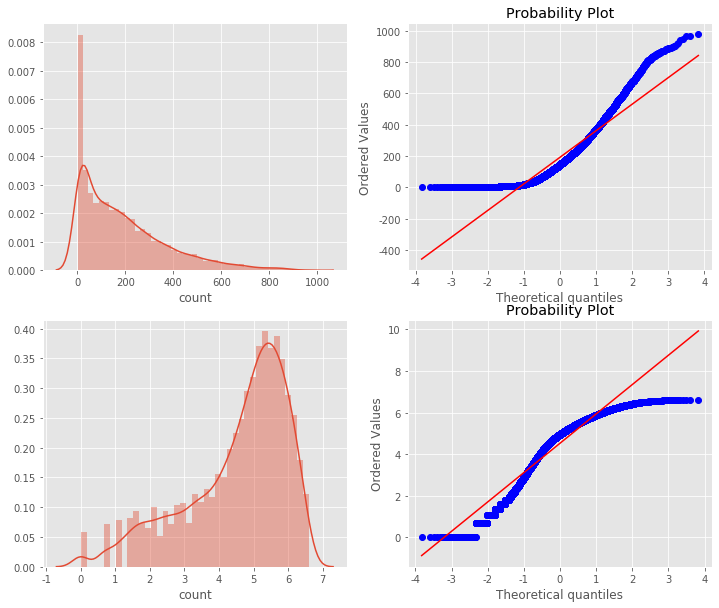

In [80]:
fig, ax = plt.subplots(2, 2, figsize=(12,10))
sns.distplot(train['count'], ax=ax[0,0])
stats.probplot(train['count'], dist='norm', fit=True, plot=ax[0,1]) # stats.probplot: Q-Q plot을 그리는 메서드
sns.distplot(np.log(trainWithoutOutliers['count']), ax=ax[1,0])
stats.probplot(np.log(trainWithoutOutliers['count']), dist='norm', fit=True, plot=ax[1,1])

## 6. Visualizing Count vs. (Month, Season, Hour, Weekday, Usertype)  
  
1) month 별 평균 count - 범주형 1개 vs 연속형 1개  
2) season별 hour마다의 평균 count - 범주형 2개 vs 연속형 1개  
3) weekday별 hour마다의 평균 count - 범주형 2개 vs 연속형 1개      
4) usertype별 hour마다의 평균 count - - 범주형 2개 vs 연속형 1개    
  
에 대한 시각화를 진행하고 인사이트를 도출해보자.

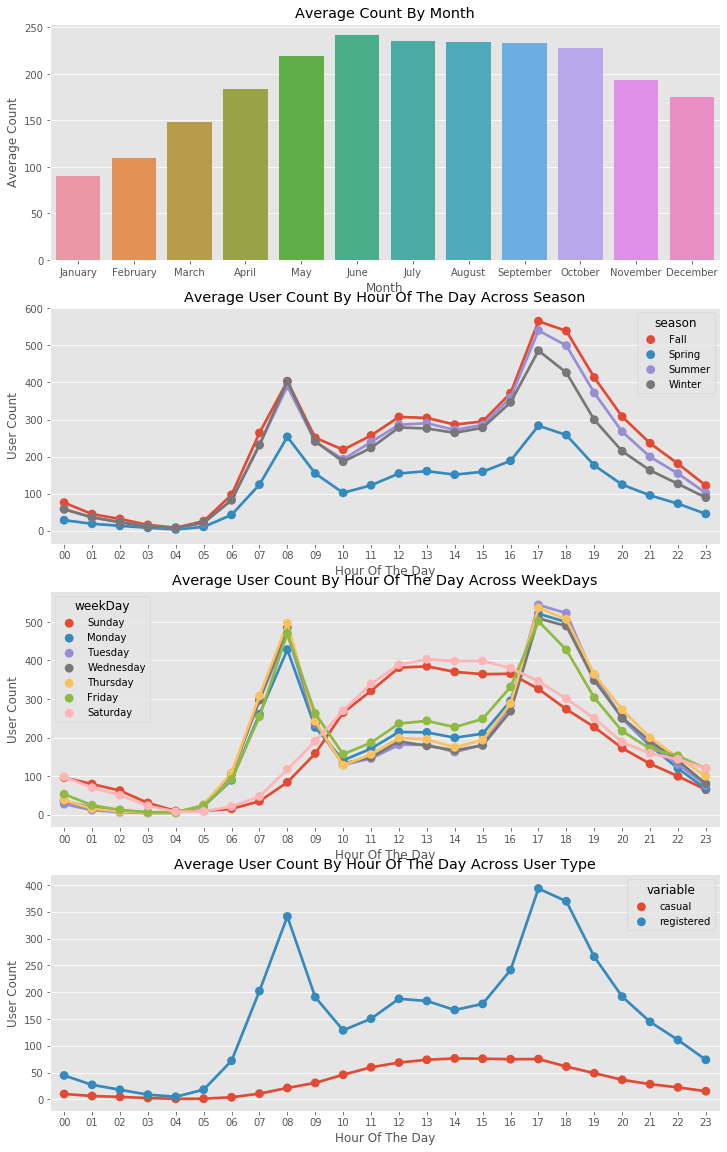

In [164]:
fig, ax = plt.subplots(4, 1, figsize=(12,20))
sortOrder = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August','September','October','November','December']
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

# month별 평균 count를 구한 뒤 count 순으로 정렬하기
monthAggregated = pd.DataFrame(train.groupby('month')['count'].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by='count', ascending=False)
sns.barplot(x='month', y='count', data=monthSorted, order=sortOrder, ax=ax[0])
ax[0].set(xlabel='Month', ylabel='Average Count', title='Average Count By Month')

# season별 시간마다의 평균 count를 구한 뒤 그래프 그리기
hourAggregated = pd.DataFrame(train.groupby(['hour','season'], sort=True)['count'].mean().reset_index())
sns.pointplot(x=hourAggregated['hour'], y=hourAggregated['count'], hue=hourAggregated['season'], join=True, ax=ax[1])
ax[1].set(xlabel='Hour Of The Day', ylabel='User Count', title = 'Average User Count By Hour Of The Day Across Season', label='big')

# weekDay(요일)별 시간마다의 평균 count를 구한 뒤 그래프 그리기
hourAggregated = pd.DataFrame(train.groupby(['hour','weekDay'])['count'].mean()).reset_index()
sns.pointplot(x=hourAggregated['hour'], y=hourAggregated['count'], hue=hourAggregated['weekDay'], hue_order=hueOrder, join=True, ax=ax[2])
ax[2].set(xlabel='Hour Of The Day', ylabel='User Count', title='Average User Count By Hour Of The Day Across WeekDays')

# usertype별 hour마다의 평균 count를 구한 뒤 그래프 그리기
# usertype(casual, registered)을 hour 기준으로 melt 시킨 데이터프레임을 이용하자.
hourTransformed = pd.melt(train[['hour','casual','registered']], id_vars=['hour'], value_vars=['casual','registered'])
hourAggregated = hourTransformed.groupby(['hour','variable'])['value'].mean().reset_index()

sns.pointplot(x=hourAggregated['hour'], y=hourAggregated['value'], hue=hourAggregated['variable'], join=True, ax=ax[3])
ax[3].set(xlabel='Hour Of The Day', ylabel='User Count', title='Average User Count By Hour Of The Day Across User Type')

plt.show()

- 그림1&2) 사람들은 여름과 가을(season: Summer, Fall)에 더 자전거를 빌리는 경향이 있다. 아마 날씨가 좋기 때문인 것 같다. 그래프를 보면 6월~10월에 자전거에 대한 수요가 상대적으로 더 높다.  
  

- 그림3) 토요일,일요일을 제외하고 평일에는 확실히 아침(7AM\~8AM)과 저녁(5PM\~6PM)에 자전거를 더 빌리는 경향이 있다. 아마 학생과 직장인의 출퇴근 시간과 맞물리기 때문일 것이다.  
  
  
- 그림3) 아침(7AM\~8AM)과 저녁(5PM\~6PM)에 자전거를 더 빌리는 경향은 토요일과 일요일에는 보이지 않는 것을 명백하게 확인가능하다. 오히려 토요일과 일요일에는 10AM ~ 4PM까지 자전거를 더 빌린다. --> 월\~금 // 토\~일 로 변수를 나누면 더 모델에 도움이 될 것 같다.  
  
  
- 그림3&4) 아침(7AM\~8AM)과 저녁(5PM\~6PM)에 가장 큰 기여를 하는 것은 명백하게 registered user에 의해서다.